One-dimensional Schrodinger equation - time evolution
Wavepacket energy:    0.012493255501361697
Potential type:       barrier
Potential height V0:  0.01
Barrier thickness:    15


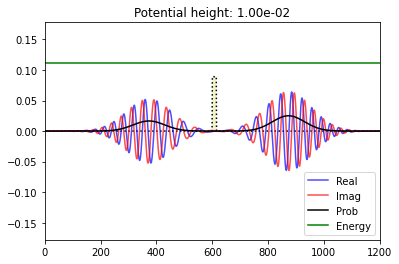

In [ ]:
#  Numerical and plotting libraries
import numpy as np
import pylab

# Set pylab to interactive mode so plots update when run outside ipython
pylab.ion()

#=============================================================================
# Utility functions
#  Defines a quick Gaussian pulse function to act as an envelope to the wave
#  function.

def Gaussian(x,t,sigma):
    """  A Gaussian curve.
        x = Variable
        t = time shift
        sigma = standard deviation      """
    return np.exp(-(x-t)**2/(2*sigma**2))

def free(npts):
    "Free particle."
    return np.zeros(npts)

def step(npts,v0):
    "Potential step"
    v = free(npts)
    v[int(npts/2):] = v0
    return v

def barrier(npts,v0,thickness):
    "Barrier potential"
    v = free(npts)
    v[int(npts/2) : int(npts/2) + thickness] = v0
    return v

def fillax(x,y,*args,**kw):
    """Fill the space between an array of y values and the x axis.
    All args/kwargs are passed to the pylab.fill function.
    Returns the value of the pylab.fill() call.
    """
    xx = np.concatenate((x,np.array([x[-1],x[0]],x.dtype)))
    yy = np.concatenate((y,np.zeros(2,y.dtype)))
    return pylab.fill(xx, yy, *args,**kw)

#=============================================================================
#
#  Simulation Constants.  Be sure to include decimal points on appropriate
#  variables so they become floats instead of integers.
#

N    = 1200     #  Number of spatial points.
T    = 5*N      #  Number of time steps.  5*N is a nice value for terminating
                #  before anything reaches the boundaries.
Tp   = 50       #  Number of time steps to increment before updating the plot.
dx   = 1.0e0    #  Spatial resolution
m    = 1.0e0    #  Particle mass
hbar = 1.0e0    #  Plank's constant
X    = dx*np.linspace(0,N,N)        #  Spatial axis.

# Potential parameters.  By playing with the type of potential and the height
# and thickness (for barriers), you'll see the various transmission/reflection
# regimes of quantum mechanical tunneling.
V0   = 1.0e-2   #  Potential amplitude (used for steps and barriers)
THCK = 15       # "Thickness" of the potential barrier (if appropriate
                # V-function is chosen)

# Uncomment the potential type you want to use here:
# Zero potential, packet propagates freely.
#POTENTIAL = 'free'

# Potential step.  The height (V0) of the potential chosen above will determine
# the amount of reflection/transmission you'll observe
#POTENTIAL = 'step'

# Potential barrier.  Note that BOTH the potential height (V0) and thickness
# of the barrier (THCK) affect the amount of tunneling vs reflection you'll  observe.
POTENTIAL = 'barrier'

#  Initial wave function constants
sigma = 40.0 # Standard deviation on the Gaussian envelope (remember Heisenberg
             #  uncertainty).
x0 = round(N/2) - 5*sigma # Time shift
k0 = np.pi/20 # Wavenumber (note that energy is a function of k)

# Energy for a localized gaussian wavepacket interacting with a localized
# potential (so the interaction term can be neglected by computing the energy
# integral over a region where V=0)
E = (hbar**2/2.0/m)*(k0**2 + 0.5/sigma**2)


#=============================================================================
# Code begins
#
# You shouldn't need to change anything below unless you want to actually play
# with the numerical algorithm or modify the plotting.
#
#  Fill in the appropriate potential function (is there a Python equivalent to
#  the SWITCH statement?).
if POTENTIAL=='free':
    V = free(N)
elif POTENTIAL=='step':
    V = step(N,V0)
elif POTENTIAL=='barrier':
    V = barrier(N,V0,THCK)
else:
    raise ValueError("Unrecognized potential type: %s" % POTENTIAL)
#  More simulation parameters.  The maximum stable time step is a function of
#  the potential, V.

Vmax = V.max()            #  Maximum potential of the domain.
dt   = hbar/(2*hbar**2/(m*dx**2)+Vmax)         #  Critical time step.
c1   = hbar*dt/(m*dx**2)                       #  Constant coefficient 1.
c2   = 2*dt/hbar                               #  Constant coefficient 2.
c2V  = c2*V  # pre-compute outside of update loop

# Print summary info
print ('One-dimensional Schrodinger equation - time evolution')
print ('Wavepacket energy:   ',E)
print ('Potential type:      ',POTENTIAL)
print ('Potential height V0: ',V0)
print ('Barrier thickness:   ',THCK)

#  Wave functions.  Three states represent past, present, and future.
psi_r = np.zeros((3,N)) #  Real 3 row N column
psi_i = np.zeros((3,N)) #  Imaginary
psi_p = np.zeros(N,)   # Observable probability (magnitude-squared
                          #  of the complex wave function).
                          # array of 1 row N column

#  Temporal indexing constants, used for accessing rows of the wavefunctions.
PA = 0                 #  Past
PR = 1                 #  Present
FU = 2                 #  Future

#  Initialize wave function.  A present-only state will "split" with half the
#  wave function propagating to the left and the other half to the right.
#  Including a "past" state will cause it to propagate one way.

xn = range(1, int(N/2))
x = X[xn]/dx    #  Normalized position coordinate
gg = Gaussian(x, x0, sigma)

cx = np.cos(k0*x)
sx = np.sin(k0*x)

psi_r[PR,xn] = cx*gg
psi_i[PR,xn] = sx*gg

psi_r[PA,xn] = cx*gg
psi_i[PA,xn] = sx*gg
# Initial normalization of wavefunctions
#   Compute the observable probability.
psi_p = psi_r[PR]**2 + psi_i[PR]**2


#  Normalize the wave functions so that the total probability in the simulation
#  is equal to 1.
P   = dx * psi_p.sum()                      #  Total probability.
nrm = np.sqrt(P)
psi_r /= nrm
psi_i /= nrm
psi_p /= P


#  Initialize the figure and axes.

pylab.figure()

xmin = X.min()
xmax = X.max()

ymax = 1.5*(psi_r[PR]).max()

pylab.axis([xmin, xmax, -ymax, ymax])

#  Initialize the plots with their own line objects.  The figures plot MUCH
#  faster if you simply update the lines as opposed to redrawing the entire
#  figure.  For reference, include the potential function as well.

lineR, = pylab.plot(X,psi_r[PR],'b',alpha=0.7,label='Real')
lineI, = pylab.plot(X,psi_i[PR],'r',alpha=0.7,label='Imag')
lineP, = pylab.plot(X,6*psi_p,'k',label='Prob')

pylab.title('Potential height: %.2e' % V0)

# For non-zero potentials, plot them and shade the classically forbidden region
# in light red, as well as drawing a green line at the wavepacket's total
# energy, in the same units the potential is being plotted.

if Vmax !=0 :
    # Scaling factor for energies, so they fit in the same plot as the
    # wavefunctions
    Efac = ymax/2.0/Vmax
    V_plot = V*Efac
    pylab.plot(X,V_plot,':k',zorder=0)   #  Potential line.
    fillax(X,V_plot, facecolor='y', alpha=0.2,zorder=0)
    # Plot the wavefunction energy, in the same scale as the potential
    pylab.axhline(E*Efac,color='g',label='Energy',zorder=1)
pylab.legend(loc='lower right')
pylab.draw()
# I think there's a problem with pylab, because it resets the xlim after
# plotting the E line.  Fix it back manually.
pylab.xlim(xmin,xmax)


#  Direct index assignment is MUCH faster than using a spatial FOR loop, so
#  these constants are used in the update equations.  Remember that Python uses
#  zero-based indexing.

IDX1 = range(1,N-1)                            #  psi [ k ]
IDX2 = range(2,N)                              #  psi [ k + 1 ]
IDX3 = range(0,N-2)                            #  psi [ k - 1 ]

for t in range(T+1):
    # Precompute a couple of indexing constants, this speeds up the computation

    psi_rPR = psi_r[PR]
    psi_iPR = psi_i[PR]

    #  Apply the update equations.
    psi_i[FU,IDX1] = psi_i[PA,IDX1] + \
                      c1*(psi_rPR[IDX2] - 2*psi_rPR[IDX1] +
                          psi_rPR[IDX3])
    psi_i[FU] -= c2V*psi_r[PR]

    psi_r[FU,IDX1] = psi_r[PA,IDX1] - \
                      c1*(psi_iPR[IDX2] - 2*psi_iPR[IDX1] +
                          psi_iPR[IDX3])
    psi_r[FU] += c2V*psi_i[PR]

    #  Increment the time steps.  PR -> PA and FU -> PR
    psi_r[PA] = psi_rPR
    psi_r[PR] = psi_r[FU]
    psi_i[PA] = psi_iPR
    psi_i[PR] = psi_i[FU]
    #  Only plot after a few iterations to make the simulation run faster.
    if t % Tp == 0:
        #  Compute observable probability for the plot.
        psi_p = psi_r[PR]**2 + psi_i[PR]**2
        #  Update the plots.
        lineR.set_ydata(psi_r[PR])
        lineI.set_ydata(psi_i[PR])
        # Note: we plot the probability density amplified by a factor so it's a
        # bit easier to see.
        lineP.set_ydata(6*psi_p)

        pylab.draw()
# So the windows don't auto-close at the end if run outside ipython
pylab.ioff()
pylab.show()